# Preprocess original dataset

Prerequisites:
- [Download original dataset](https://www.cvl.isy.liu.se/research/trafficSigns/) (only annotated parts)
- place all files in `raw-data` folder in project root with this structure

!["Folder structure"](../docs/structure.png)

In [1]:
!unzip ../raw-data/set1/Set1Part0.zip -d ../raw-data/images
!unzip ../raw-data/set2/Set2Part0.zip -d ../raw-data/images

!cat ../raw-data/set1/annotations.txt > ../raw-data/annotations.txt
!echo -en '\n' >> ../raw-data/annotations.txt
!cat ../raw-data/set2/annotations.txt >> ../raw-data/annotations.txt

Archive:  ../raw-data/set1/Set1Part0.zip
  inflating: ../raw-data/images/1277381619Image000001.jpg  
  inflating: ../raw-data/images/1277381619Image000006.jpg  
  inflating: ../raw-data/images/1277381619Image000011.jpg  
  inflating: ../raw-data/images/1277381619Image000016.jpg  
  inflating: ../raw-data/images/1277381624Image000002.jpg  
  inflating: ../raw-data/images/1277381624Image000007.jpg  
  inflating: ../raw-data/images/1277381624Image000012.jpg  
  inflating: ../raw-data/images/1277381624Image000017.jpg  
  inflating: ../raw-data/images/1277381655Image000002.jpg  
  inflating: ../raw-data/images/1277381655Image000007.jpg  
  inflating: ../raw-data/images/1277381655Image000012.jpg  
  inflating: ../raw-data/images/1277381655Image000017.jpg  
  inflating: ../raw-data/images/1277381655Image000022.jpg  
  inflating: ../raw-data/images/1277381671Image000002.jpg  
  inflating: ../raw-data/images/1277381671Image000007.jpg  
  inflating: ../raw-data/images/1277381671Image000012.jpg  

In [2]:
import os
import shutil
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

rng = np.random.default_rng()

In [3]:
IMAGE_SIZE = (1280, 960)

CLASSES = {
    '120_SIGN': 0,
    '110_SIGN': 1,
    '100_SIGN': 2,
    '90_SIGN': 3,
    '80_SIGN': 4,
    '70_SIGN': 5,
    '60_SIGN': 6,
    '50_SIGN': 7,
    '30_SIGN': 8,
    'GIVE_WAY': 9,
    'NO_PARKING': 10,
    'NO_STOPPING_NO_STANDING': 11,
    'PASS_EITHER_SIDE': 12,
    'PASS_LEFT_SIDE': 13,
    'PASS_RIGHT_SIDE': 14,
    'PEDESTRIAN_CROSSING': 15,
    'PRIORITY_ROAD': 16,
    'STOP': 17,
    'URDBL': 18,
    'OTHER': 19,
}

root_dir = '..'

raw_data_dir = os.path.join(root_dir, 'raw-data')
annotations_file = os.path.join(raw_data_dir, 'annotations.txt')
images_folder = os.path.join(raw_data_dir, 'images')

data_dir = os.path.join(root_dir, 'data')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [5]:
def train_test_split():
    image_names = os.listdir(images_folder)
    rng.shuffle(image_names)
    ind = len(image_names) // 5
    print(len(image_names), ind)

    image_info = dict()
    with open(annotations_file, 'r') as f:
        for line in f:
            filename = line.split(':')[0]
            image_info[filename] = line
    print(len(image_info))

    if not os.path.isdir(data_dir):
            os.mkdir(data_dir)

    def prosess(tag, items):
        print(f"Processing {tag} {len(items)}")
        items_info = []
        to_dir = os.path.join(data_dir, tag)
        if not os.path.isdir(to_dir):
            os.mkdir(to_dir)
        to_img_dir = os.path.join(to_dir, 'images')
        if not os.path.isdir(to_img_dir):
            os.mkdir(to_img_dir)
        for filename in items:
            shutil.copy(os.path.join(images_folder, filename), to_img_dir)
            if filename in image_info:
                items_info.append(image_info[filename])
        with open(os.path.join(to_dir, 'annotations.txt'), 'w') as f:
            f.write(''.join(items_info))

    prosess('train', image_names[ind:])
    prosess('test', image_names[:ind])

train_test_split()

3777 755
3777
Processing train 3022
Processing test 755


In [12]:
# В датасете несколько ошибок в числах (странные символы), иногда пропущены переходы на новую строку

def parse_annotations(file_path):
    content = {
        'filename': [],
        'visibility': [],
        'signType': [],
        'signName': [],
        'lrx': [],
        'lry': [],
        'ulx': [],
        'uly': [],
    }
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(':')
            if len(parts) % 2 == 1:
                print(parts)
                raise Exception("Invalid format")

            for i in range(0, len(parts), 2):
                filename, signs_str = parts[i], parts[i + 1]

                if not filename.endswith('.jpg'):
                    print(filename)
                    raise Exception("Invalid format")
                
                if signs_str.endswith('.jpg'):
                    print(signs_str)
                    raise Exception("Invalid format")

                for raw_sign in signs_str.split(';')[:-1]:
                    if raw_sign == 'MISC_SIGNS' or not raw_sign.strip():
                        continue
                    else:
                        visibility, lrx, lry, ulx, uly, signType, signName = map(lambda x: x.strip(), raw_sign.split(','))
                        content['filename'].append(filename)
                        content['visibility'].append(visibility) # насколько хорошо видно знак
                        content['signType'].append(signType) # INFORMATION | MANDATORY | WARNING
                        content['signName'].append(signName) # тип знака
                        content['lrx'].append(float(lrx)) # нижний правый x
                        content['lry'].append(float(lry)) # нижний правый y
                        content['ulx'].append(float(ulx)) # нижний правый x
                        content['uly'].append(float(uly)) # нижний правый y
    return pd.DataFrame(content)

parse_annotations(os.path.join(train_dir, 'annotations.txt'))
test_annotations = parse_annotations(os.path.join(test_dir, 'annotations.txt'))
print(len(test_annotations))
test_annotations.head()

1330


,filename,visibility,signType,signName,lrx,lry,ulx,uly
0,1277388031Image000021.jpg,VISIBLE,PROHIBITORY,90_SIGN,769.874544,766.987646,746.201844,742.666379
1,1277108134Image000003.jpg,BLURRED,INFORMATION,PRIORITY_ROAD,583.301042,537.317645,566.215263,520.428255
2,1277108134Image000003.jpg,BLURRED,INFORMATION,PRIORITY_ROAD,558.205731,544.448161,549.573633,536.191371
3,1277382613Image000006.jpg,VISIBLE,INFORMATION,PEDESTRIAN_CROSSING,146.780232,690.234369,118.659020,662.552551
4,1277382613Image000006.jpg,VISIBLE,MANDATORY,PASS_RIGHT_SIDE,147.590102,723.643872,117.666535,694.089732


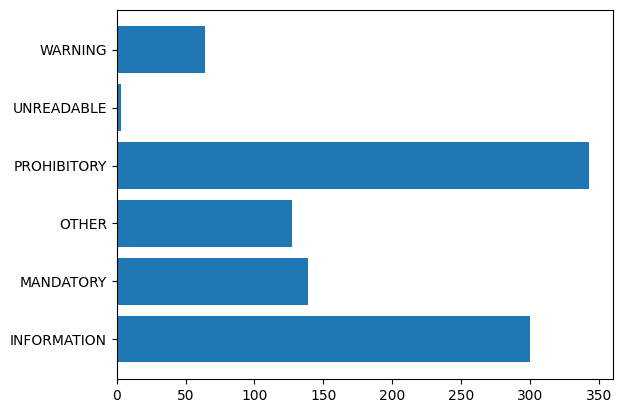

In [13]:
unique_types = test_annotations.groupby('signType')['filename'].nunique()

fig, ax = plt.subplots()
ax.barh(unique_types.index, unique_types.values)
plt.show()

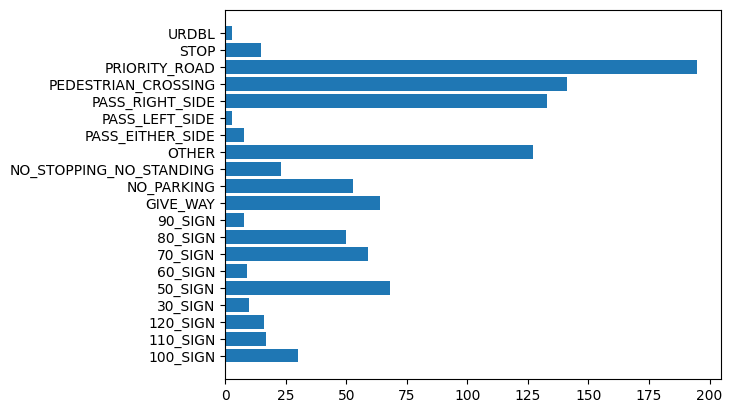

In [14]:
unique_types = test_annotations.groupby('signName')['filename'].nunique()

fig, ax = plt.subplots()
ax.barh(unique_types.index, unique_types.values)
plt.rc('font', size=8)
plt.show()

In [15]:
def make_labels(dir):
    annotations = parse_annotations(os.path.join(dir, 'annotations.txt'))
    labels_dir = os.path.join(dir, 'labels')
    if not os.path.isdir(labels_dir):
        os.mkdir(labels_dir)
    images_dir = os.path.join(dir, 'images')
    for pic in os.listdir(images_dir):
        signs = annotations[annotations['filename'] == pic]
        name = ''.join(pic.split('.')[:-1])
        with open(os.path.join(labels_dir, f"{name}.txt"), 'w') as f:
            lines = []
            for _, row in signs.iterrows():
                signName, lrx, lry, ulx, uly = row['signName'], row['lrx'], row['lry'], row['ulx'], row['uly']
                line = [
                    CLASSES[signName],
                    (lrx + ulx) / 2 / IMAGE_SIZE[0],
                    (lry + uly) / 2 / IMAGE_SIZE[1],
                    (lrx - ulx) / IMAGE_SIZE[0],
                    (lry - uly) / IMAGE_SIZE[1],
                    ]
                lines.append(' '.join(map(str, line)))
            content = '\n'.join(lines)
            f.write(content)

make_labels(test_dir)
make_labels(train_dir)

In [16]:
!cd .. && zip -r data.zip data/ -x '.*' -x '__MACOSX'

updating: data/ (stored 0%)
updating: data/test/ (stored 0%)
updating: data/test/images/ (stored 0%)
updating: data/test/images/1277108116Image000021.jpg (deflated 0%)
updating: data/test/images/1277104235Image000072.jpg (deflated 0%)
updating: data/test/images/1277108134Image000073.jpg (deflated 0%)
updating: data/test/images/1277387167Image000002.jpg (deflated 2%)
updating: data/test/images/1277382590Image000004.jpg (deflated 1%)
updating: data/test/images/1277105103Image000014.jpg (deflated 2%)
updating: data/test/images/1277383388Image000036.jpg (deflated 4%)
updating: data/test/images/1277108194Image000109.jpg (deflated 0%)
updating: data/test/images/1277382922Image000011.jpg (deflated 0%)
updating: data/test/images/1277385929Image000006.jpg (deflated 1%)
updating: data/test/images/1277387640Image000006.jpg (deflated 1%)
updating: data/test/images/1277387882Image000042.jpg (deflated 0%)
updating: data/test/images/1277107950Image000011.jpg (deflated 1%)
updating: data/test/images/1